<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/initializing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.4 MB/s eta 0:00:00


In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.1 MB/s eta 0:00:00


In [4]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import sys, gc, traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl, yl = 'image', 'label'
name= "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [7]:
def get_model():
  return nn.Sequential(conv(1, 8), conv(8, 16), conv(16, 32), conv(32, 64),
                       conv(64, 10, act=False), nn.Flatten()).to(def_device)

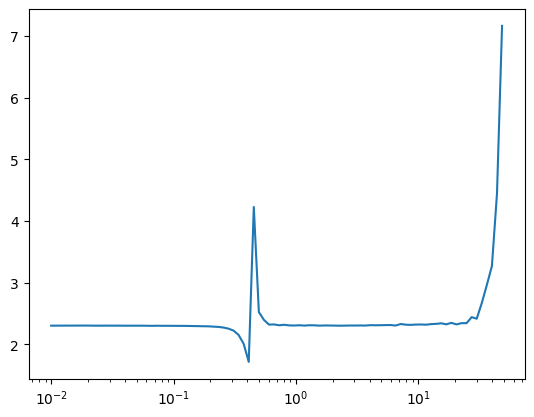

In [8]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)


accuracy,loss,epoch,train
0.259,2.024,0,train
0.673,0.896,0,eval


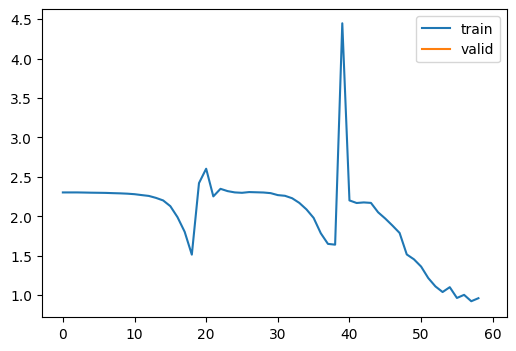

In [10]:
learn.fit(1)

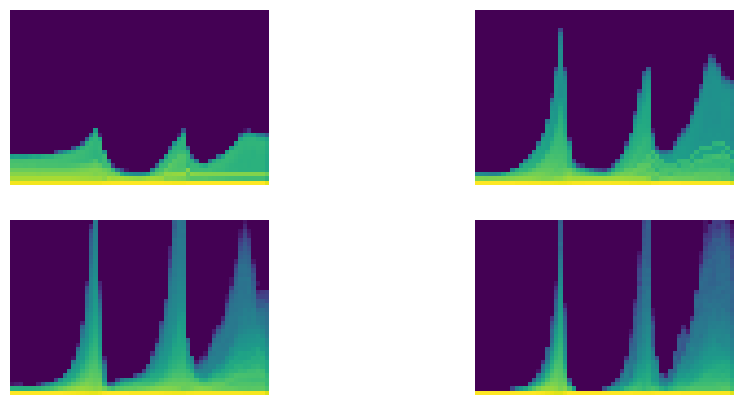

In [11]:
astats.color_dim()

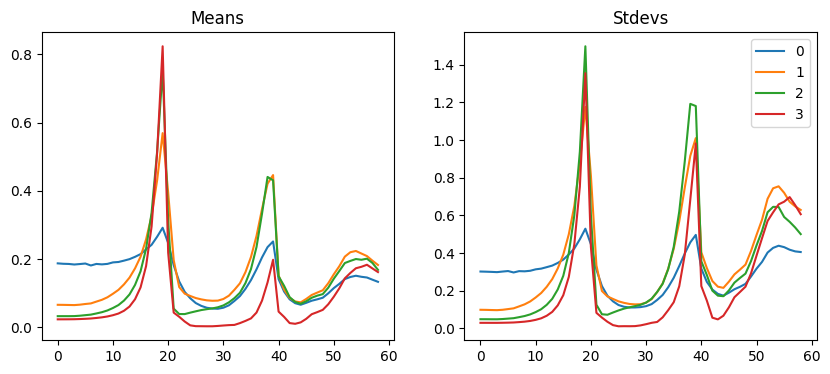

In [12]:
astats.plot_stats()

In [13]:
def clean_ipython_hist():
  if not 'get_ipython' in globals(): return
  ip = get_ipython()
  user_ns = ip.user_ns
  ip.displayhook.flush()
  pc = ip.displayhook.prompt_count + 1
  for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
  user_ns.update(dict(_i='', _ii='', _iii=''))
  hm = ip.history_manager
  hm.input_hist_parsed[:] = [''] * pc
  hm.input_hist_raw[:] = [''] * pc
  hm._i = hm._ii = hm._iii = hm._i00 = ''

In [14]:
def clean_tb():
  if hasattr(sys, 'last_tracebreak'):
    traceback.clear_frames(sys.last_traceback)
    delattr(sys, 'last_traceback')
  if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
  if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [15]:
def clean_mem():
  clean_tb()
  clean_ipython_hist()
  gc.collect()
  torch.cuda.empty_cache()

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [17]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.01)
x[0:5, 0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [18]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.1)
x[0:5, 0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

In [19]:
t = torch.tensor([1.,2.,4.,18.])

In [20]:
m = t.mean(); m

tensor(6.25)

In [21]:
(t-m).mean()

tensor(0.)

In [22]:
(t-m).pow(2).mean()

tensor(47.19)

In [23]:
(t-m).abs().mean()

tensor(5.88)

In [24]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [25]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

In [26]:
t

tensor([ 1.,  2.,  4., 18.])

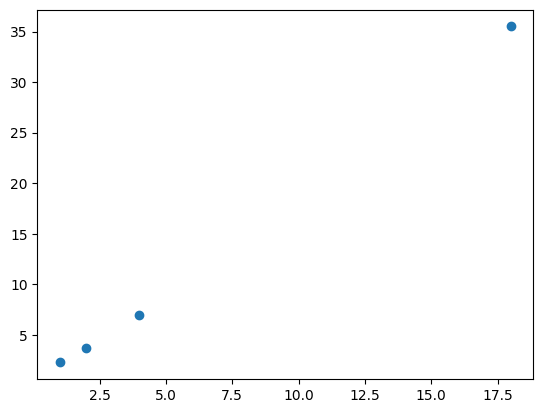

In [27]:
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [28]:
prod = (t-t.mean()) * (u-u.mean()); prod

tensor([ 51.67,  35.81,  11.57, 275.08])

In [29]:
prod.mean()

tensor(93.53)

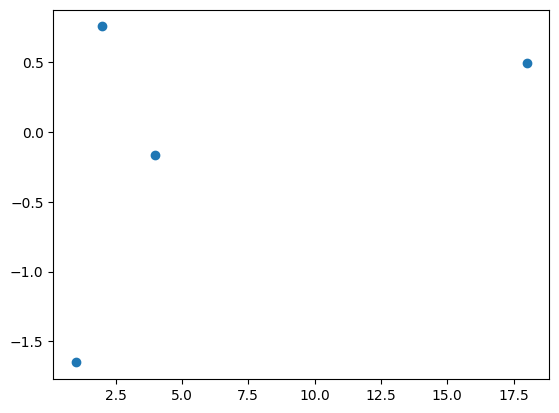

In [30]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [31]:
((t-t.mean()) * (v-v.mean())).mean()

tensor(2.91)

In [32]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(2.91)

In [33]:
cov / (t.std()*v.std())

tensor(0.34)

In [34]:
x.std()

tensor(1.13)

In [35]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.19), tensor(0.96))

In [36]:
mean, sqr = 0., 0.
for i in range(100):
  x = torch.randn(100)
  a = torch.randn(512, 100)
  y = a @ x
  mean += y.mean().item()
  sqr += y.pow(2).mean().item()
mean/100, sqr/100

(-0.021637050323188304, 101.61874702453613)

In [37]:
mean, sqr = 0.,0.
for i in range(10000):
  x = torch.randn(1)
  a = torch.randn(1)
  y = a*x
  mean += y.item()
  sqr += y.pow(2).item()
mean/10000, sqr/10000

(-0.003184134499988704, 0.9690546516017775)

In [38]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [39]:
from math import sqrt

In [40]:
w1 = torch.randn(100, 50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50, 1) / sqrt(50)
b2 = torch.zeros(1)

In [41]:
def lin(x, w, b): return x @ w + b

In [42]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.01), tensor(0.98))

In [43]:
def relu(x): return x.clamp_min(0.)

In [44]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.58))

In [45]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [46]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * sqrt(2/100)))
x[0:5, 0:5]

tensor([[0.40, 0.00, 0.00, 0.28, 0.00],
        [0.37, 0.00, 0.00, 0.30, 0.00],
        [0.28, 0.00, 0.00, 0.20, 0.00],
        [0.36, 0.00, 0.00, 0.30, 0.00],
        [0.25, 0.00, 0.00, 0.19, 0.00]])

In [47]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [48]:
def init_weights(m):
  if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [49]:
model.apply(init_weights);

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


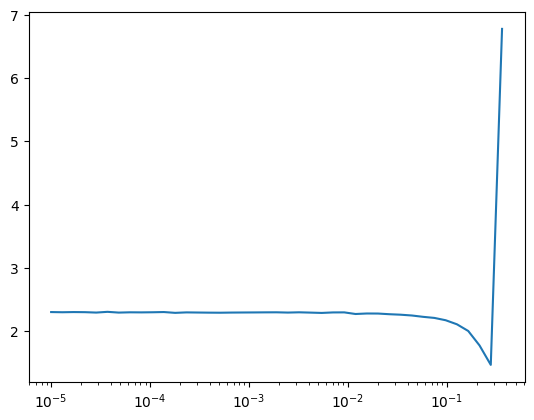

In [50]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [51]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)